In [63]:
using Distributed, SharedArrays

using LinearAlgebra, SparseArrays, StatsBase, Distances, IterativeSolvers
using NearestNeighbors, OptimalTransport, MultivariateStats
using Distributed, SharedArrays
include("util.jl")
using Plots

using LightGraphs, GraphPlot
# using Cairo, Compose

In [64]:

#Make a spiral with k arms and n points per arm
# PARAM: 
# arms: array of integers, n-th entry is the number of points on n-th arm
# todo: take a function f as input for sscaling along arm
function general_kSpiral(arms; st = 0.5, ed = 5)
    total_so_far = 0
    total_pts = sum(arms)
    class_num = length(arms)
    
    #Divide a full rotation into k intervals
    θ = range(0, 2π, length = class_num+1)
    
    #Make a matrix of labels
    inds = ones(Int32, total_pts) 
    
    X = zeros(total_pts, 2)
    T = zeros(total_pts)


    for i in 1:class_num

        t = ed * rand(arms[i]).^2 .+ st

#         t = ed * LinRange(0, 1, arms[i]).^2 .+ st
        
        sort!(t)
        
        #Plug into the parametrization for the spiral
        x = @. [cos(t) * t sin(t) * t] 

        #Rotate to give spiral effect
        X[total_so_far+1 : total_so_far + arms[i], :] = rotate(x', θ[i]) 
        T[total_so_far+1 : total_so_far + arms[i], :] = t

        #Label arm i as i
        inds[total_so_far+1 : total_so_far + arms[i]] .= i 

        total_so_far += arms[i]

    end
    
    return X, T, inds
end



general_kSpiral (generic function with 1 method)

In [65]:
# arms = ones(10)
# arms = 1:10

# arms = 50 * (sin.(LinRange(0, 2*π, 10)) .+ 1.2)
# arms = collect(range(1, step = 0.5, 5))

# arms[2:2:10] = 1.5 * ones(5)

# arms = @. Int(floor(30*(arms)))

arms = ones(10)
N_arm = 200
arms = @. Int(floor(N_arm * arms))
N = sum(arms)
K = length(arms)

10

In [66]:
X, T, labels_all = general_kSpiral(arms)
dim = 100

noise = rand(N, dim)

X = 0.0*noise[:, 1:2] + X

2000×2 Matrix{Float64}:
  0.43881     0.239739
  0.439268    0.2404
  0.439512    0.240753
  0.439619    0.240907
  0.44047     0.242141
  0.445242    0.249184
  0.446524    0.251111
  0.447672    0.25285
  0.448492    0.2541
  0.450298    0.256877
  0.452206    0.259845
  0.45477     0.263891
  0.455373    0.264854
  ⋮          
 -1.78829    -4.64018
 -1.54119    -4.78729
 -0.975035   -5.0571
 -0.956962   -5.06433
 -0.864707   -5.09997
 -0.619344   -5.18496
 -0.529081   -5.21278
 -0.365683   -5.25858
 -0.0931969  -5.32238
  0.431159   -5.40316
  0.463653   -5.40641
  0.65336    -5.42142

In [67]:
scatter(X[:, 1], X[:, 2], marker_z = labels_all, c = :lighttest, 
    ticks = nothing, leg=false,  grid=false, showaxis = false, aspect_ratio=1.0)
savefig("../figures/Varying_density_spiral/SpiralData")

In [68]:

prop = 0.1

ink_idx, ink_color = sample_labels(N, labels_all, prop)

@time Q, accuracy, γ_qot = simulate_QOT(X, N, K, labels_all, ink_idx, ink_color, 1, prop)

soft_label, infer_label = get_labels(Q, K)

Solved for 2000 nodes, K= 10, ϵ= 1, η= 8, accuracy= 0.9171270718232044
 24.833811 seconds (799.96 k allocations: 5.493 GiB, 2.22% gc time, 2.06% compilation time)


([1.000000000072401, 1.0000000000366682, 1.0000000000728735, 1.0000000000729454, 1.0000000000370444, 1.0000000000771583, 1.000000000078287, 1.0000000000793086, 1.0000000000800446, 1.0000000000410507  …  9.035645789583992, 9.102417629615463, 9.233636028359953, 9.304386765136433, 9.595231608756597, 9.29601929440856, 8.825410517814234, 8.465671975434576, 8.44785080985997, 8.144141700186912], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [69]:
length(labels_all)

2000

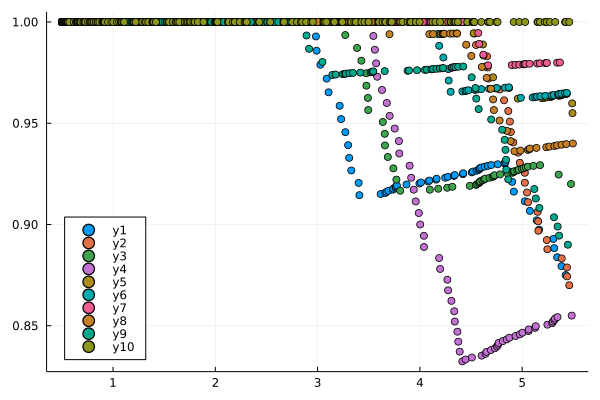

In [70]:
fig = plot()

for arm in 1:10

    infered_arm = infer_label[labels_all .== arm]
    n = length(infered_arm)
    y = zeros(n)

    for k in 1:n
        y[k] = sum(infered_arm[1:k] .== labels_all[labels_all .== arm][1:k]) / k
    end

    scatter!(T[labels_all .== arm], y, legend = :bottomleft)
end
display(fig)
# savefig("../figures/Varying_density_spiral/QOT_t_vs_acc")

In [71]:
size(γ_qot)
N

2000

In [72]:
function makeEdgeWeights(γ)
    ew = Int[]
    for i in 1:N, j in 1:N # iterate over all combinations of columns
        w = floor(1e3*γ_qot[i,j] )     # calculate how many times (i,j) occurs
        if w > 0
            push!(ew, w)
    #         add_edge!(g, i, j, w)
        end
    end
    return ew
end

makeEdgeWeights (generic function with 1 method)

In [73]:
c = distinguishable_colors(10, colorant"yellow")
# print(infer_label)
c[infer_label]


In [74]:
c[labels_all]

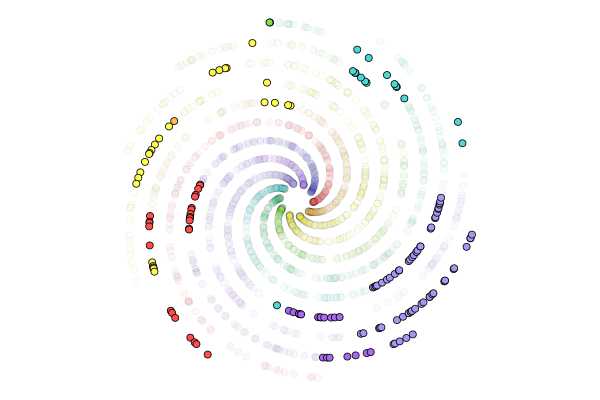

In [84]:
inds = infer_label .!= labels_all
r = 1:N
mislabel_qot = r[inds]


hd = scatter(X[:, 1], X[:, 2], marker_z = infer_label, alpha=0.05, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

scatter!(X[mislabel_qot, 1], X[mislabel_qot, 2], marker_z = infer_label[mislabel_qot], alpha=1.00, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

savefig("../figures/Varying_density_spiral/QOT_infered925")
display(hd)


# G = LightGraphs.Graph(γ_qot+γ_qot')

# ew = makeEdgeWeights(γ_qot)

# gp_ew = gplot(G, X[:,1], -X[:,2], nodefillc=c[labels_all], edgelinewidth=ew)
# gp = gplot(G, X[:,1], -X[:,2])

# draw(PNG("../figures/Varying_density_spiral/QOT_graph.png", 16cm, 16cm), gp)

# display(gp)
# display(gp_ew)

In [76]:
@time Q_knn, accuracy, γ_knn = simulate_KNN(X, N, K, labels_all, ink_idx, ink_color, 5, 0.01, 1.0)

soft_label, infer_label_knn = get_labels(Q_knn, K)

Solved for 2000 nodes, K= 10, neighbours= 5, η= 8, accuracy= 0.8657458563535911 
 17.238042 seconds (322.78 k allocations: 119.735 MiB, 0.14% gc time, 1.30% compilation time)


([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  7.609406503426118, 7.609522675622706, 7.585472416454795, 7.5050601057127215, 7.7418913201661805, 7.454045092115422, 6.9909287197414125, 6.089118193180484, 6.085068117402547, 5.75871104120233], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

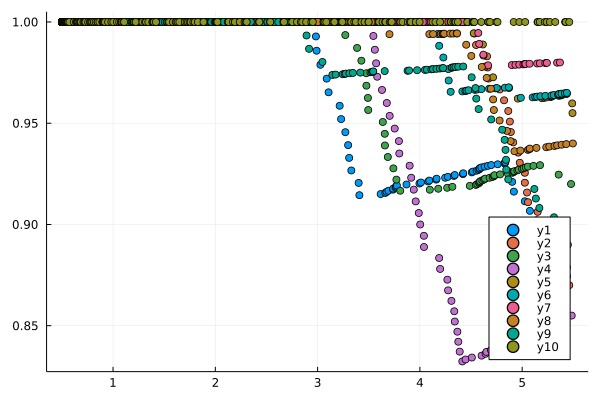

In [77]:
fig = plot()

for arm in 1:10

    infered_arm = infer_label[labels_all .== arm]
    n = length(infered_arm)
    y = zeros(n)

    for k in 1:n
        y[k] = sum(infered_arm[1:k] .== labels_all[labels_all .== arm][1:k]) / k
    end

    scatter!(T[labels_all .== arm], y, legend = :bottomright)
end
display(fig)
# savefig("../figures/Varying_density_spiral/KNN_t_vs_acc")

In [78]:
c[labels_all]

In [79]:
c[infer_label_knn]

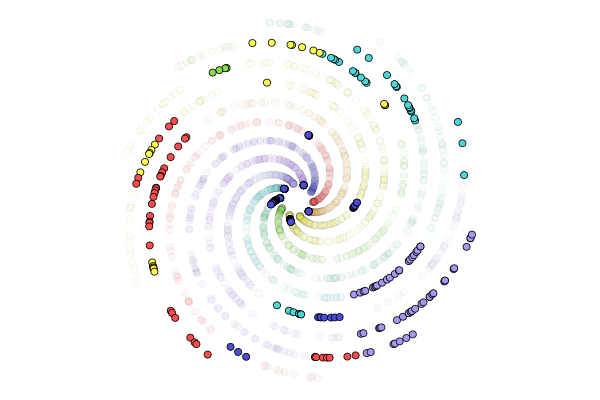

In [85]:
inds_knn = infer_label_knn .!= labels_all
r = 1:N
mislabel_knn = r[inds_knn]



hd = scatter(X[:, 1], X[:, 2], marker_z = infer_label_knn, alpha=0.05, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

scatter!(X[mislabel_knn, 1], X[mislabel_knn, 2], marker_z = infer_label_knn[mislabel_knn], alpha=1.00, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

savefig("../figures/Varying_density_spiral/KNN_infered857")

display(hd)

# ew = makeEdgeWeights(γ_knn)

# G = LightGraphs.Graph(γ_knn+γ_knn')
# # gp_ew = gplot(G, X[:,1], -X[:,2], edgelinewidth=ew)
# gp = gplot(G, X[:,1], -X[:,2])

# # draw(PNG("../figures/Varying_density_spiral/QOT_graph.png", 16cm, 16cm), gp)

# display(gp)
# display(gp_ew)

In [81]:
# for k in [3, 5, 7, 10, 15, 20, 25 ]
    
#     @time _, accuracy, _ = simulate_KNN(X, N, K, labels_all, ink_idx, ink_color, k, 0.1, 1.0)
    
# end

┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport /zfs/users/tmats/tmats/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


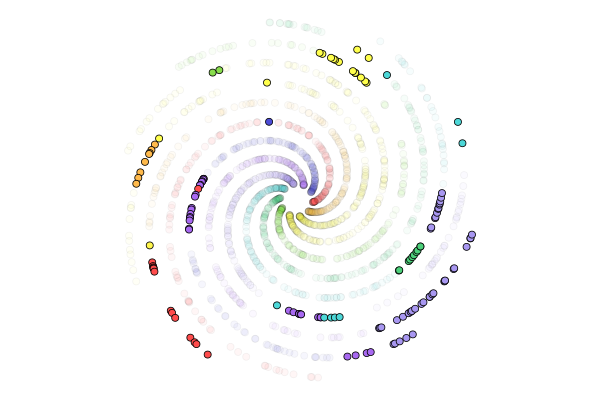

Solved for 2000 nodes, ε=0.0001, accuracy= 0.9276243093922651


In [82]:
ink_ind, S, P, Q_ent = make_selection_matrices(ink_idx, ink_color, N, K)
# C, μ, ν = make_ot_params(X)
C = pairwise(SqEuclidean(), X, X, dims=1) #Euclidean distance between nodes
C ./= mean(C)
ε_ent = 0.0001
γ_ent = sinkhorn(ones(N), ones(N), C, ε_ent)
solve_for_likelihood!(γ_ent, Q_ent, P)

soft_label_ent, infer_label_ent = get_labels(Q_ent, K)

#Check what percentage of inferred labels match 
accuracy = get_accuracy(labels_all, ink_ind, infer_label_ent, N)
println("Solved for $N nodes, ε=$ε_ent, accuracy= ", accuracy)

inds_ent = infer_label_ent .!= labels_all
r = 1:N
mislabel_ent = r[inds_ent]

hd = scatter(X[:, 1], X[:, 2], marker_z = infer_label_ent, alpha=0.05, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

scatter!(X[mislabel_ent, 1], X[mislabel_ent, 2], marker_z = infer_label_ent[mislabel_ent], alpha=1.00, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

# savefig("../figures/Varying_density_spiral/KNN_infered857")

display(hd)

In [83]:
c[infer_label_ent]